# Applying MacSGP to the 10x Xenium CRC dataset

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import os

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append(r'/import/home2/share/yqzeng/MacSGP/codes')
import MacSGP

In [2]:
RAW_PATH = "/home/yzengbj/data/colorectal_cancer" # Raw data
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/CRC" # Raw data
os.makedirs(os.path.join(DATA_PATH), exist_ok = True)

## Cell type deconvolution using MacSGP

In [3]:
adata_ref = sc.read_10x_h5(os.path.join(RAW_PATH, 'sc', "HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5"))
meta = pd.read_csv(os.path.join(RAW_PATH, "HumanColonCancer_VisiumHD/MetaData/SingleCell_MetaData.csv"), index_col=0)
adata_ref.obs = meta.loc[adata_ref.obs.index]

adata_ref = adata_ref[adata_ref.obs["QCFilter"] == 'Keep', :]

In [9]:
adata_st = sc.read_h5ad(os.path.join(DATA_PATH, "xenium_p2_crc.h5ad"))
adata_st.obsm['spatial'] = np.array([adata_st.obs['x'], adata_st.obs['y']]).T

In [10]:
MacSGP.utils.Cal_Spatial_Net(adata_st, mode='KNN', k_cutoff=6)

Calculating spatial neighbor graph ...
The graph contains 2214760 edges, 326460 spots.
6.784169576670955 neighbors per spot on average.


In [12]:
adata_st, adata_basis = MacSGP.utils.preprocess(adata_st,adata_ref,
                                                celltype_ref_col = "Level2",
                                                n_hvg_group = 150)

Finding highly variable genes...
407 highly variable genes selected.
Calculate basis for deconvolution...
Preprocess ST data...


In [13]:
model = MacSGP.model.Model_deconv(adata_st, adata_basis, n_layers =4, training_steps=10000)
model.train(step_interval=1000, use_amp=False)
adata_st = model.eval()

  0%|          | 1/10000 [00:00<1:43:38,  1.61it/s]

Step: 0, Loss: 216.8512, d_loss: 213.2997, f_loss: 35.5146


 10%|█         | 1001/10000 [06:51<1:01:44,  2.43it/s]

Step: 1000, Loss: 64.5341, d_loss: 62.1040, f_loss: 24.3014


 20%|██        | 2001/10000 [13:42<54:50,  2.43it/s]  

Step: 2000, Loss: 59.8627, d_loss: 57.4985, f_loss: 23.6416


 30%|███       | 3001/10000 [20:33<48:02,  2.43it/s]

Step: 3000, Loss: 58.4121, d_loss: 56.0898, f_loss: 23.2228


 40%|████      | 4001/10000 [27:24<41:09,  2.43it/s]

Step: 4000, Loss: 57.7609, d_loss: 55.4757, f_loss: 22.8520


 50%|█████     | 5001/10000 [34:15<34:18,  2.43it/s]

Step: 5000, Loss: 57.4019, d_loss: 55.1460, f_loss: 22.5588


 60%|██████    | 6001/10000 [41:06<27:26,  2.43it/s]

Step: 6000, Loss: 57.2084, d_loss: 54.9799, f_loss: 22.2857


 70%|███████   | 7001/10000 [47:57<20:36,  2.43it/s]

Step: 7000, Loss: 57.0164, d_loss: 54.8167, f_loss: 21.9972


 80%|████████  | 8001/10000 [54:48<13:42,  2.43it/s]

Step: 8000, Loss: 56.9264, d_loss: 54.7555, f_loss: 21.7086


 90%|█████████ | 9001/10000 [1:01:39<06:51,  2.43it/s]

Step: 9000, Loss: 56.7884, d_loss: 54.6482, f_loss: 21.4019


100%|██████████| 10000/10000 [1:08:30<00:00,  2.43it/s]


In [15]:
adata_st.write_h5ad(os.path.join(DATA_PATH, "xenium.h5ad"))
adata_basis.write_h5ad(os.path.join(DATA_PATH, "xenium_basis.h5ad"))

Dropping cell types: ['Epithelial', 'Memory B', 'NK', 'SM Stress Response', 'Tumor I']


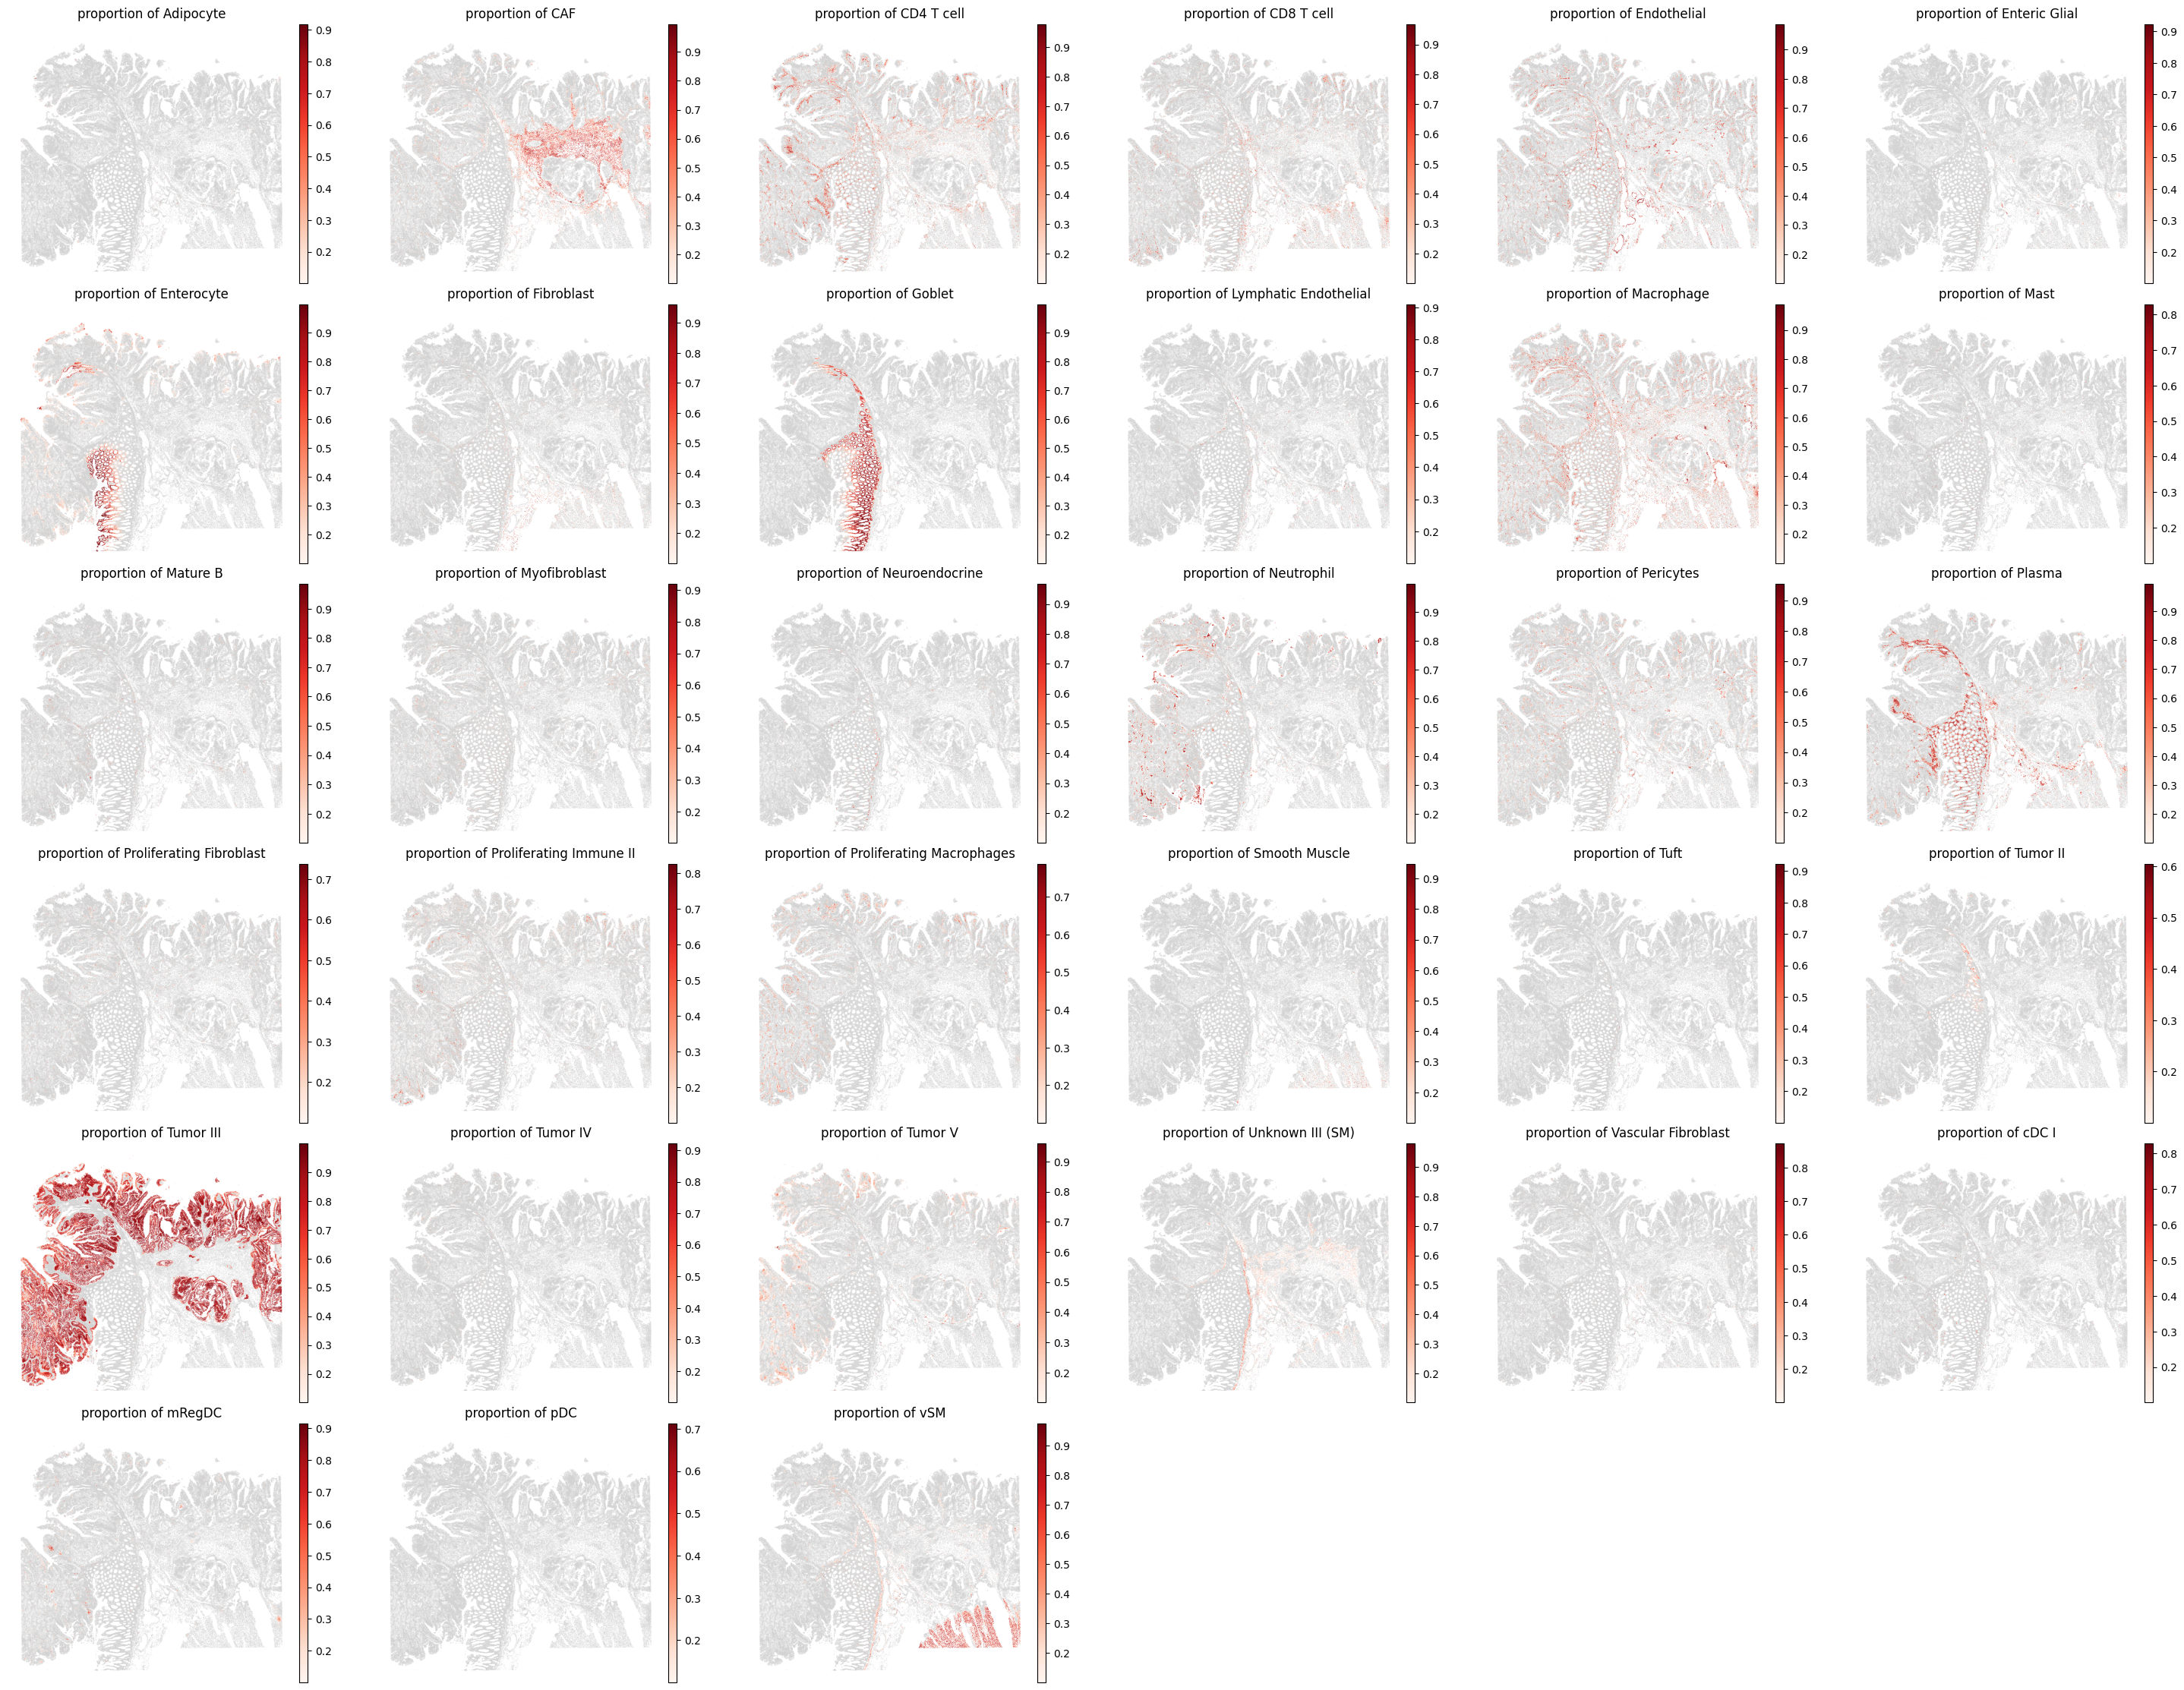

In [18]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_st, index='proportion',
                proportion_threshold=0.1, num_threshold=100, 
                cmap='Reds', 
                spot_size=10, 
                ncols=6)

## Applying MacSGP to detect cell-type-specific SGPs

In [4]:
DATA_PATH = "/import/home2/share/yqzeng/MacSGP/data/CRC" # Raw data
SAVE_PATH = "/import/home2/share/yqzeng/MacSGP/results/CRC" # Deconvolution results
os.makedirs(os.path.join(SAVE_PATH), exist_ok = True)

In [3]:
adata_st = ad.read_h5ad(os.path.join(DATA_PATH, "xenium.h5ad"))
adata_basis = ad.read_h5ad(os.path.join(DATA_PATH, "xenium_basis.h5ad"))

In [4]:
filterd_ct = ['CAF', 'CD8 T cell', 'Endothelial', 'Enteric Glial', 'Enterocyte',
       'Fibroblast', 'Goblet', 'Lymphatic Endothelial', 'Macrophage', 'Mast',
       'Myofibroblast', 'Neuroendocrine', 'Neutrophil', 'Pericytes', 'Plasma',
       'Proliferating Fibroblast', 'Proliferating Immune II',
       'Proliferating Macrophages', 'Tuft', 'Tumor III', 'Tumor V', 'cDC I',
       'mRegDC', 'vSM']

In [5]:
adata_st.obsm['proportion'] = adata_st.obsm['proportion'][filterd_ct]
adata_basis = adata_basis[filterd_ct]

In [ ]:
model = MacSGP.model.Model(adata_st, adata_basis, n_layers=3, training_steps=3000, coef_reg=0.06)

model.train(step_interval=200, test=False, gene_patch=True, patch_size=206, use_amp=True)
adata_result = model.eval()

  0%|          | 1/3000 [00:03<3:18:22,  3.97s/it]

Step: 0, Loss: 63.0689, d_loss: 59.5186, f_loss: 35.5019, reg_loss: 0.0000


  7%|▋         | 201/3000 [02:41<38:03,  1.23it/s]

Step: 200, Loss: 56.5643, d_loss: 53.2687, f_loss: 26.2307, reg_loss: 0.2421


 13%|█▎        | 401/3000 [05:27<35:26,  1.22it/s]

Step: 400, Loss: 53.4631, d_loss: 49.8114, f_loss: 25.6305, reg_loss: 0.3919


 20%|██        | 601/3000 [08:13<32:41,  1.22it/s]

Step: 600, Loss: 52.0441, d_loss: 48.2661, f_loss: 25.3986, reg_loss: 0.4458


 27%|██▋       | 801/3000 [10:59<32:11,  1.14it/s]

Step: 800, Loss: 51.2495, d_loss: 47.4112, f_loss: 25.2326, reg_loss: 0.4734


 33%|███▎      | 1001/3000 [13:46<28:37,  1.16it/s]

Step: 1000, Loss: 50.7439, d_loss: 46.8607, f_loss: 25.0528, reg_loss: 0.4961


 40%|████      | 1201/3000 [16:32<24:34,  1.22it/s]

Step: 1200, Loss: 50.4322, d_loss: 46.5251, f_loss: 24.9391, reg_loss: 0.5087


 47%|████▋     | 1401/3000 [19:19<23:03,  1.16it/s]

Step: 1400, Loss: 50.1865, d_loss: 46.2457, f_loss: 24.8386, reg_loss: 0.5245


 53%|█████▎    | 1601/3000 [22:10<20:31,  1.14it/s]

Step: 1600, Loss: 50.0480, d_loss: 46.0778, f_loss: 24.8198, reg_loss: 0.5357


 60%|██████    | 1801/3000 [24:59<16:28,  1.21it/s]

Step: 1800, Loss: 49.9273, d_loss: 45.9359, f_loss: 24.6766, reg_loss: 0.5485


 67%|██████▋   | 2001/3000 [27:45<13:38,  1.22it/s]

Step: 2000, Loss: 49.8393, d_loss: 45.7978, f_loss: 24.5882, reg_loss: 0.5698


 73%|███████▎  | 2201/3000 [30:33<11:41,  1.14it/s]

Step: 2200, Loss: 49.7507, d_loss: 45.7050, f_loss: 24.3860, reg_loss: 0.5786


 80%|████████  | 2401/3000 [33:19<08:12,  1.22it/s]

Step: 2400, Loss: 49.6991, d_loss: 45.6528, f_loss: 24.2842, reg_loss: 0.5825


 87%|████████▋ | 2601/3000 [36:07<05:42,  1.16it/s]

Step: 2600, Loss: 49.6538, d_loss: 45.6020, f_loss: 24.1874, reg_loss: 0.5879


 93%|█████████▎| 2801/3000 [38:54<02:44,  1.21it/s]

Step: 2800, Loss: 49.6235, d_loss: 45.5727, f_loss: 24.0999, reg_loss: 0.5907


100%|██████████| 3000/3000 [41:40<00:00,  1.20it/s]


In [ ]:
adata_result.write_h5ad(os.path.join(SAVE_PATH, "xenium.h5ad"))

In [5]:
adata_result = ad.read_h5ad(os.path.join(SAVE_PATH, "xenium.h5ad"))

Dropping cell types: []


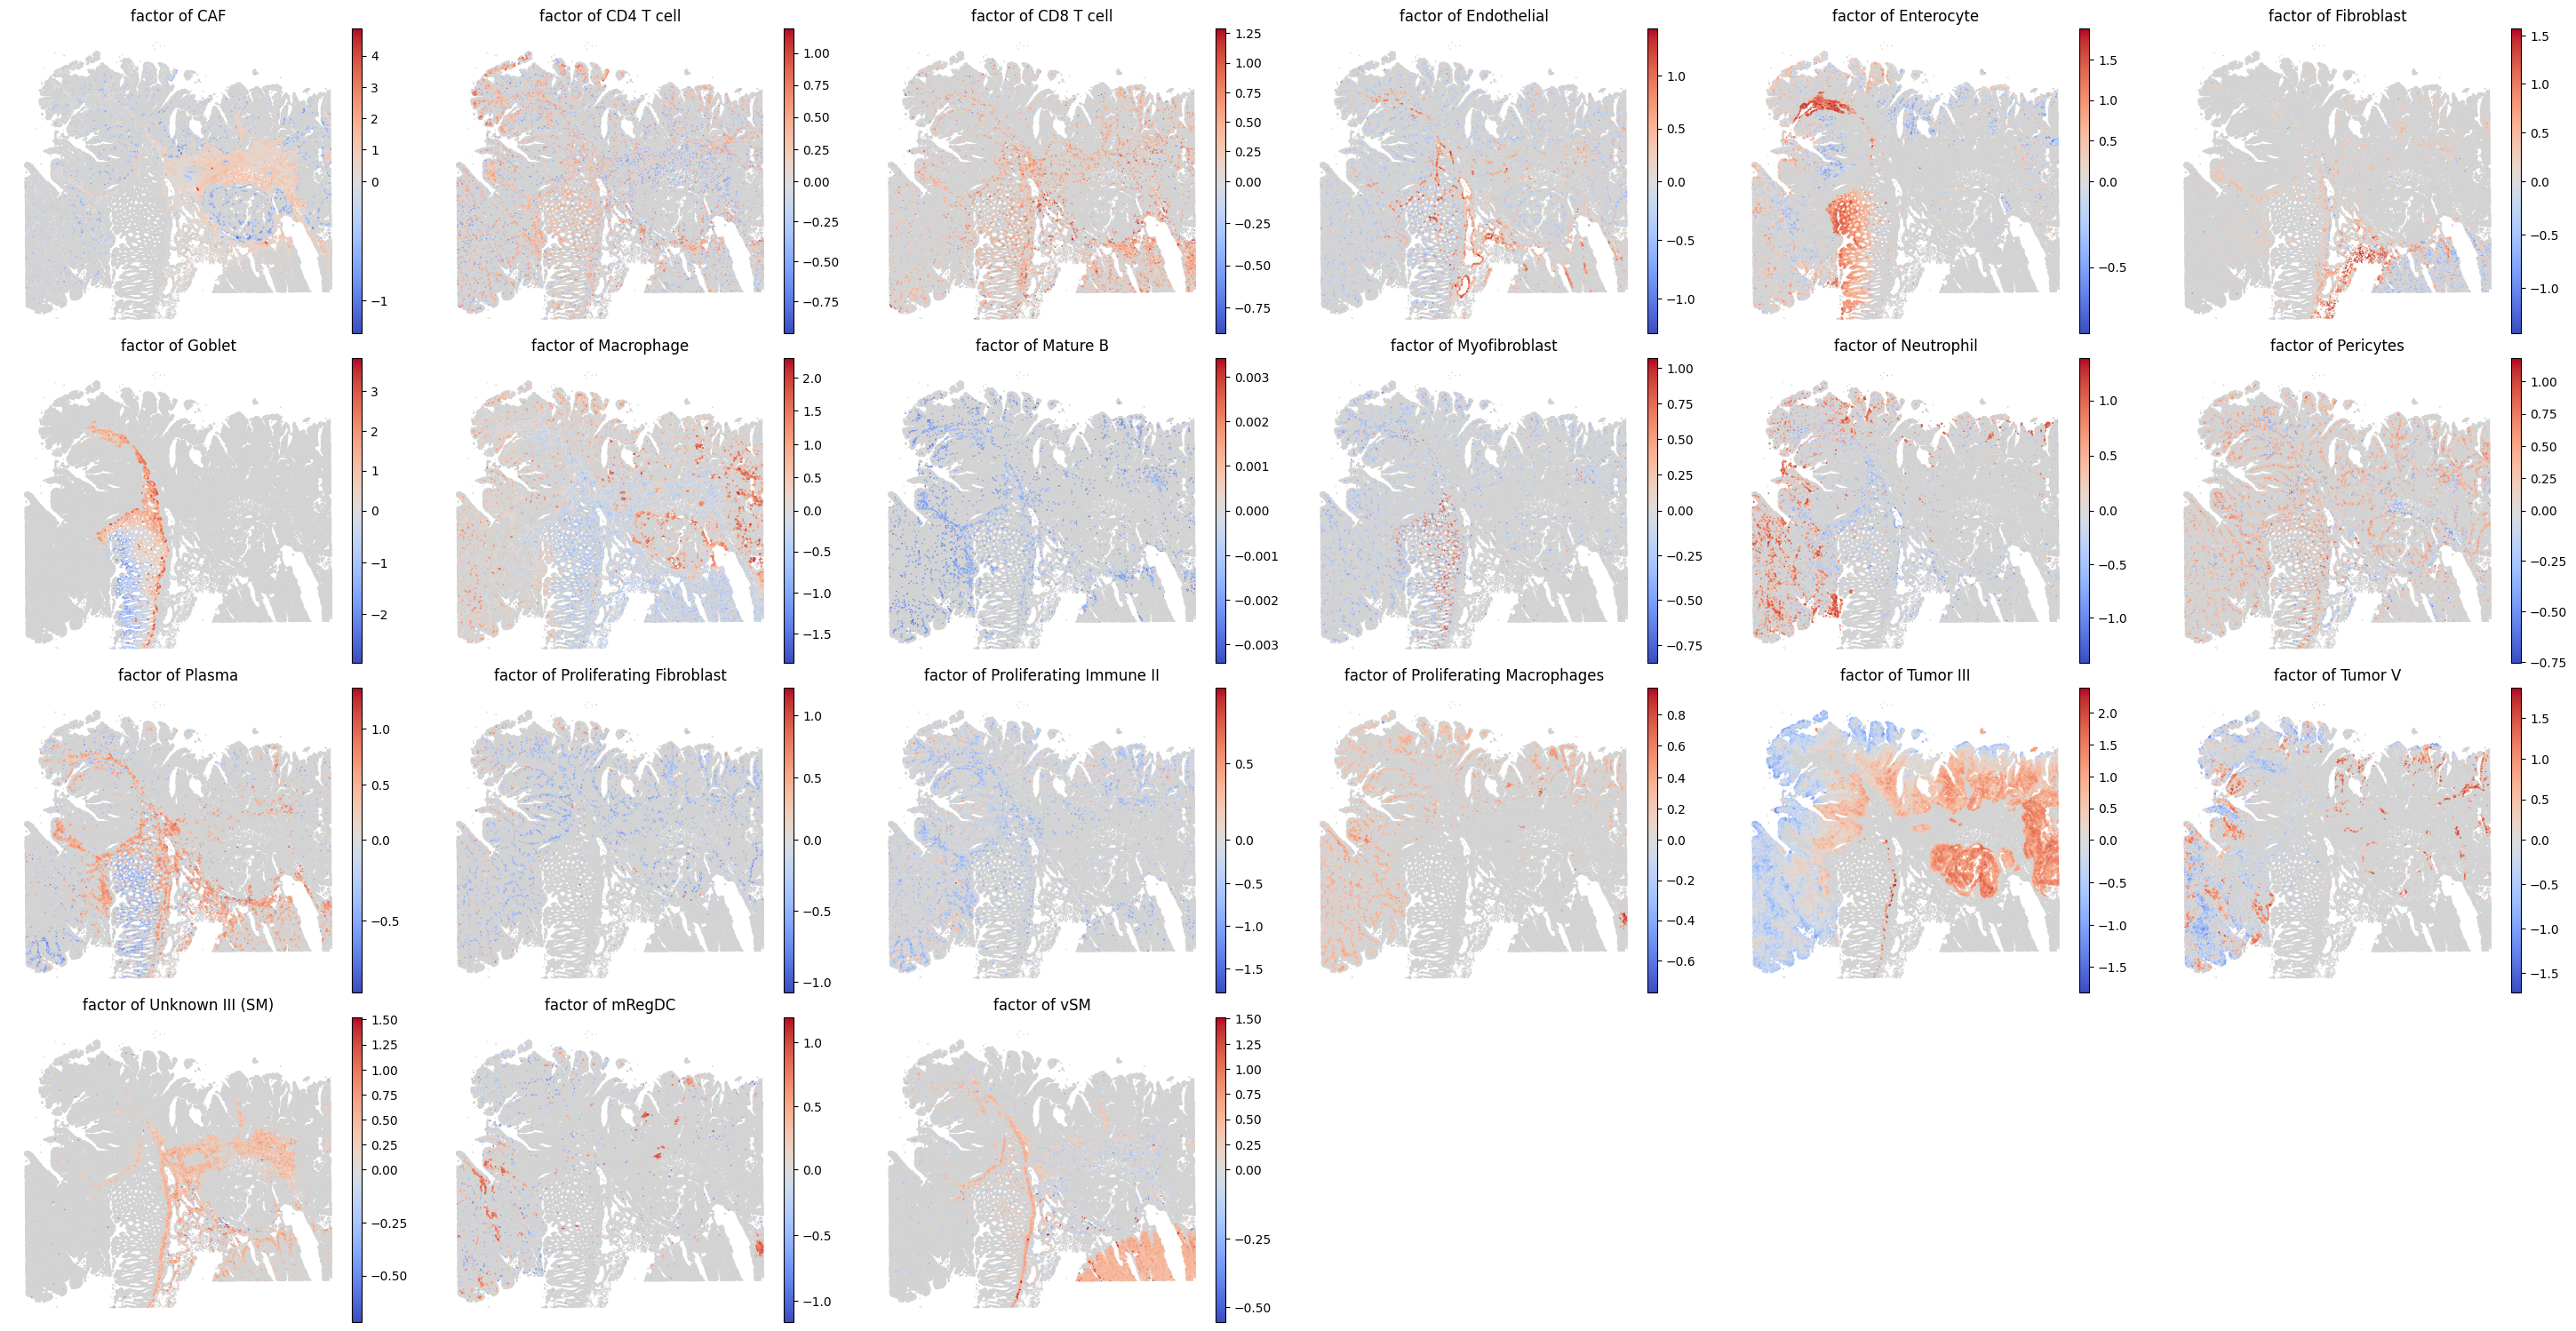

In [7]:
from MacSGP.vis import plot_spatial_ct

plot_spatial_ct(adata_result, index='factor', hide_image=True,
                proportion_threshold=0.1, num_threshold=100, 
                cmap='coolwarm', 
                spot_size=30, 
                ncols=6)